In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import random
import matplotlib.patches as mpatches

In [87]:
df = pd.read_csv("dataset.csv")
df.head()

,song_id,keyword_1,keyword_2,keyword_3,genre
0,74,guitar,happy,distorted,rock
1,103,brass,energetic,melodic,classical
2,201,banjo,happy,acoustic,country
3,194,synth,energetic,heavy,hip-hop
4,184,synth,energetic,slow,hip-hop


In [88]:
np.random.seed(42)
random.seed(42)

In [89]:
ALL_GENRES = {}
GENRES_BY_COLOR = {}
for idx, row in df.iterrows():
    if row['genre'] not in ALL_GENRES:
        ALL_GENRES[row['genre']] = [idx]
        GENRES_BY_COLOR[row['genre']] = (random.random(), random.random(), random.random())
    else:
        ALL_GENRES[row['genre']].append(idx)

ALL_GENRES, GENRES_BY_COLOR

({'rock': [0,
   6,
   7,
   15,
   18,
   21,
   25,
   26,
   27,
   29,
   30,
   35,
   40,
   45,
   49,
   52,
   61,
   68,
   70,
   92,
   95,
   98,
   104,
   107,
   111,
   130,
   131,
   133,
   134,
   141],
  'classical': [1,
   5,
   8,
   11,
   13,
   16,
   32,
   33,
   34,
   44,
   50,
   51,
   69,
   72,
   73,
   78,
   94,
   100,
   102,
   105,
   109,
   116,
   117,
   119,
   122,
   124,
   125],
  'country': [2,
   9,
   12,
   14,
   20,
   31,
   37,
   43,
   46,
   48,
   54,
   55,
   59,
   60,
   63,
   67,
   77,
   80,
   82,
   90,
   99,
   114,
   118,
   121,
   123,
   128,
   129,
   139,
   140],
  'hip-hop': [3,
   4,
   19,
   22,
   23,
   28,
   42,
   53,
   56,
   57,
   62,
   64,
   66,
   74,
   75,
   79,
   81,
   84,
   91,
   93,
   101,
   112,
   115,
   126,
   127,
   132,
   135,
   137,
   138,
   142],
  'pop': [10,
   17,
   24,
   36,
   38,
   39,
   41,
   47,
   58,
   65,
   71,
   76,
   83,
   85,
   86,
   

## Generating word embeddings for the keywords using BoW

In [90]:
def create_embeddings(keyword):

    ans = np.zeros(26)
    for i in keyword:
        ans[ord(i.upper()) - ord('A')] = 1

    return ans

create_embeddings('slow')

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 1., 0., 0., 0.])

In [91]:
def give_df_keyword_embeddings(df):
    arr = []
    vocab = None
    for idx, row in df.iterrows():
        t = []
        vec = create_embeddings(row['keyword_1'])
        t.append(vec)
        vec = create_embeddings(row['keyword_2'])
        t.append(vec)
        vec = create_embeddings(row['keyword_3'])
        t.append(vec)
        arr.append(t)

    return np.array(arr)

In [92]:
embeddings = give_df_keyword_embeddings(df)
embeddings

array([[[1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[1., 1., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.]],

       [[1., 1., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 1., 0.],
        [1., 0., 1., ..., 0., 0., 0.]],

       ...,

       [[1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 1., 0.],
        [0., 0., 1., ..., 0., 1., 0.]],

       [[0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 1., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])

## Dimensionality Reduction for each keyword matrix

In [93]:
class PCA:

    def __init__(self, n_components):
        self.n_components = n_components
        self.components = None
        self.mean = None

    def fit(self, X):
        self.mean = np.mean(X, axis=0)
        X = X -  self.mean

        cov = np.cov(X.T)

        eigenvectors, eigenvalues = np.linalg.eig(cov)

        eigenvectors = eigenvectors.T
        eigenvectors = np.real_if_close(eigenvectors, tol=1e-9)

        idxs = np.argsort(eigenvalues)[::-1]
        eigenvalues = eigenvalues[idxs]
        eigenvectors = eigenvectors[idxs]

        self.components = eigenvectors[:self.n_components]

    def transform(self, X):
        X = X - self.mean
        return np.dot(X, self.components.T)

In [94]:
def transform_embeddings(embeddings, PCA):

    arr = []
    for i, row in enumerate(embeddings):
        pca = PCA(2)
        pca.fit(row)
        reduced_dim_row = pca.transform(row)
        arr.append(reduced_dim_row)
    
    return np.array(arr)

transformed_embeddings = transform_embeddings(embeddings, PCA)
transformed_embeddings

array([[[-1.48029737e-16, -5.21913818e-01],
        [-1.64365531e-16, -5.21913818e-01],
        [ 3.12395268e-16,  1.04382764e+00]],

       [[-3.27228316e-16, -3.27228316e-16],
        [ 1.88279064e-16,  1.88279064e-16],
        [ 1.38949252e-16,  1.38949252e-16]],

       [[ 8.36643598e-19,  8.66465039e-18],
        [ 8.36643598e-19, -1.73293008e-17],
        [-1.67328720e-18,  8.66465039e-18]],

       [[ 3.17274224e-17, -4.74216577e-01],
        [ 3.19113544e-17, -4.74216577e-01],
        [-6.36387769e-17,  9.48433154e-01]],

       [[-5.21913818e-01, -4.40626677e-17],
        [-5.21913818e-01,  2.06349499e-17],
        [ 1.04382764e+00,  2.34277178e-17]],

       [[ 7.77928938e-18,  7.77928938e-18],
        [ 1.73415573e-17,  1.73415573e-17],
        [-2.51208467e-17, -2.51208467e-17]],

       [[ 1.91068360e+00,  1.91068360e+00],
        [-9.55341801e-01, -9.55341801e-01],
        [-9.55341801e-01, -9.55341801e-01]],

       [[ 9.14191620e-18,  9.14191620e-18],
        [-1.828383

## Combining the embeddings into one

In [95]:
def combine_embeddings(transformed_embeddings):
    arr = []

    for i, row in enumerate(transformed_embeddings):
        t = [0, 0]
        for j, vals in enumerate(row):
            t[0] += vals[0]
            t[1] += vals[1]
        t[0] /= len(row)
        t[1] /= len(row)
        
        arr.append(t)

    return np.array(arr)

combined_embeddings = combine_embeddings(transformed_embeddings)

## Apply K-Means clustering

In [96]:
def get_squared_dis(x1, y1, x2, y2):
    return (x1 - x2)**2 + (y1 - y2)**2

In [97]:
def compute_init_centroids(K, matrix):
    random_idx = np.random.permutation(matrix.shape[0])
    
    centroids = matrix[random_idx[:K]]
    
    return centroids
    

In [98]:
def get_cluster_index(centroids, matrix, K):
    m ,n = matrix.shape
    cluster_index = np.zeros(m)

    for i in range(m):

        d = get_squared_dis(matrix[i][0], matrix[i][1], centroids[0][0], centroids[0][1])
        ans = 0
        for j in range(1, K):
            new_d = get_squared_dis(matrix[i][0], matrix[i][1], centroids[j][0], centroids[j][1])
            if(new_d < d):
                d = new_d
                ans = j

        cluster_index[i] = ans

    return cluster_index
                
            

In [99]:
def compute_centroids(cluster_index, matrix, centroids, k):
    m, n = matrix.shape
    new_centroids = []

    for i in range(k):

        x_m, y_m = 0, 0
        n = 0
        for j in range(m):
            if cluster_index[j] == i:
                x_m += matrix[j][0]
                y_m += matrix[j][1]
                n += 1

        if n != 0:
            x_m /= n
            y_m /= n

        new_centroids.append([x_m ,y_m])

    return np.array(new_centroids)

In [100]:
def run_KMeans(matrix, K, iterations):
    m, n = matrix.shape
    centroids = compute_init_centroids(K, matrix)

    for i in range(iterations):

        cluster_index = get_cluster_index(centroids, matrix, K)

        centroids = compute_centroids(cluster_index, matrix, centroids, K)

    return cluster_index, centroids

In [101]:
def cal_shilloute_dis(cluster_index, centroids, matrix, K):
    m, n = matrix.shape

    si_scores = np.zeros(K)

    for i in range(m):

        point = matrix[i]

        # calculating cohesion <intra cluster distance>
        arr = []
        for j in range(m):
            if cluster_index[j] == cluster_index[i] and i != j:
                arr.append(matrix[j])

        if len(arr) > 1:
            a_i = np.mean([get_squared_dis(point[0], point[1], other[0], other[1]) for other in arr if not np.array_equal(point, other)])
        else:
            a_i = 0


        # calculating separation <mean distance from nearest cluster>
        b_i = np.inf

        for j in range(K):
            if j == cluster_index[i]:
                continue

            arr = []
            for k in range(m):
                if cluster_index[k] == j:
                    arr.append(matrix[k])

            b_i = min(b_i, np.mean([get_squared_dis(point[0], point[1], other[0], other[1]) for other in arr]))

        # computer score
        if max(a_i, b_i) > 0 :
            si_scores =  (b_i - a_i) / max(a_i, b_i)


    return np.mean(si_scores)
        

In [102]:
def apply_clustering(matrix):
    best, K = -1, 1
    best_cluster_index, best_centroids = None, None
    
    for i in range(2, 10):
        cluster_index, centroids = run_KMeans(matrix, i, 100)
        score = cal_shilloute_dis(cluster_index, centroids, matrix, i)
        
        if score > best:
            best = score
            K = i
            best_cluster_index = cluster_index
            best_centroids = centroids
    
    return best, K, best_cluster_index, best_centroids

In [103]:
best, K, cluster_index, centroids = apply_clustering(combined_embeddings)
best, K, cluster_index, centroids

(np.float64(0.7985218508997429),
 5,
 array([1., 3., 3., 1., 4., 3., 0., 3., 2., 0., 1., 3., 3., 2., 3., 2., 2.,
        1., 3., 3., 4., 3., 3., 3., 3., 3., 0., 2., 1., 3., 3., 2., 2., 2.,
        3., 2., 3., 4., 2., 2., 3., 3., 4., 2., 3., 2., 3., 4., 3., 3., 2.,
        3., 3., 1., 3., 3., 2., 2., 1., 2., 1., 3., 3., 2., 0., 1., 3., 2.,
        2., 3., 3., 1., 3., 3., 0., 1., 2., 3., 1., 4., 0., 3., 0., 3., 2.,
        0., 0., 0., 3., 4., 3., 2., 3., 0., 1., 3., 1., 0., 3., 3., 3., 2.,
        3., 1., 0., 3., 2., 3., 2., 0., 4., 1., 3., 3., 3., 2., 4., 2., 4.,
        3., 3., 3., 0., 2., 3., 2., 1., 3., 2., 2., 1., 3., 3., 3., 0., 1.,
        3., 3., 2., 0., 3., 2., 3., 2., 3., 4., 2.]),
 array([[ 1.30614473e-16,  1.82860263e-16],
        [-5.10878259e-33,  9.83618645e-17],
        [ 8.12107583e-17,  8.86636443e-17],
        [ 6.64977332e-18,  5.49329101e-18],
        [ 8.57899610e-17,  1.68215610e-17]]))

## Graph for clustering

In [104]:
COLOR_MAP = {}
for i in range(K):
    COLOR_MAP[i] = (random.random(), random.random(), random.random())
def get_color_for_plot(i, K):
    return COLOR_MAP[i]

In [105]:
def make_graph(K, cluster_index, centroids, matrix):

    m, n = matrix.shape

    # plotting data points
    for i in range(m):
        color = get_color_for_plot(cluster_index[i], K)
        plt.scatter(matrix[i][0], matrix[i][1], marker = "o", color = color, s=50, edgecolors="black")

    # plotting centroids
    for i in range(K):
        color = get_color_for_plot(i, K)
        plt.scatter(centroids[i][0], centroids[i][1], marker = "x", color = "black")

    plt.title("Scatter Plot Based on the algorithms applied")

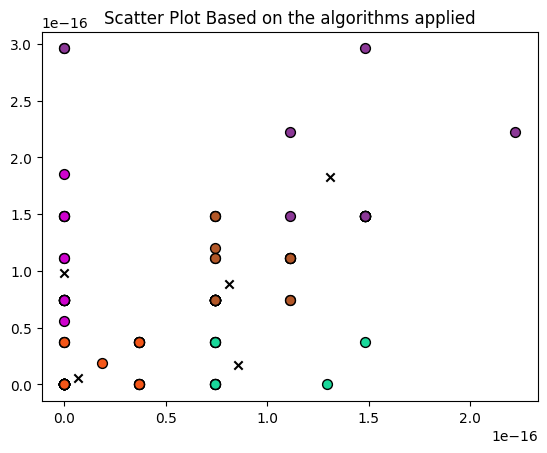

In [106]:
make_graph(K, cluster_index, centroids, combined_embeddings)

In [107]:
def give_intersection(l1, l2):
    ans = 0
    for i in l1:
        if i in l2:
            ans += 1

    return ans

In [108]:
# giving genres to clusters

def get_genre_by_cluster(cluster_index, all_genres, matrix, K):
    mapping = []

    for i in range(K):
        ans = []
        n = 0
        
        l = []
        for j in range(len(cluster_index)):
            if cluster_index[j] == i:
                l.append(j)

        for key in ALL_GENRES:
            intersection = give_intersection(ALL_GENRES[key], l)
            ans.append([intersection, key])

        ans = sorted(ans)
        ans.reverse()
        mapping.append(ans)

    return mapping

GENRE_BY_CLUSTER = get_genre_by_cluster(cluster_index, ALL_GENRES, combined_embeddings, K)
GENRE_BY_CLUSTER

[[[4, 'rock'], [4, 'pop'], [4, 'country'], [3, 'hip-hop'], [2, 'classical']],
 [[7, 'pop'], [6, 'hip-hop'], [3, 'rock'], [2, 'classical'], [1, 'country']],
 [[8, 'country'], [8, 'classical'], [7, 'pop'], [7, 'hip-hop'], [6, 'rock']],
 [[17, 'rock'],
  [14, 'classical'],
  [13, 'country'],
  [11, 'hip-hop'],
  [9, 'pop']],
 [[4, 'pop'], [3, 'hip-hop'], [3, 'country'], [1, 'classical'], [0, 'rock']]]

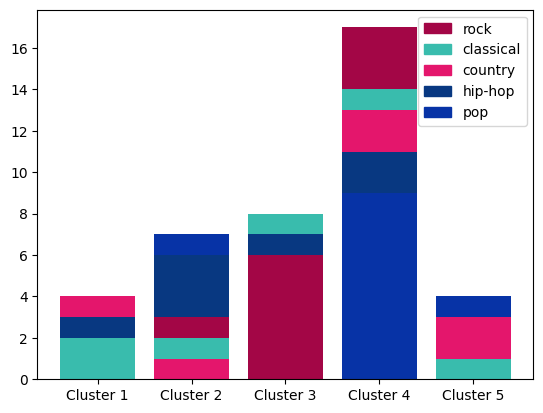

In [109]:
# stacked bar graph for genres 
for i in range(len(GENRE_BY_CLUSTER)):
    arr = []
    for j in GENRE_BY_CLUSTER[i]:
        plt.bar(f'Cluster {i + 1}', j[0], color=GENRES_BY_COLOR[j[1]])

legend_labels = []
for i in GENRES_BY_COLOR:
    patch = mpatches.Patch(color=GENRES_BY_COLOR[i], label=i)
    legend_labels.append(patch)

plt.legend(handles = legend_labels)

In [110]:
def predict(keyword_1, keyword_2, keyword_3, centroids):
    # creating keywords
    arr = []
    arr.append(create_embeddings(keyword_1))
    arr.append(create_embeddings(keyword_2))
    arr.append(create_embeddings(keyword_3))

    # appling PCA
    pca = PCA(2)
    pca.fit(arr)
    arr = pca.transform(arr)

    # combining the 3 keywords
    combined_arr = [0, 0]
    for i in arr:
        combined_arr[0] += i[0]
        combined_arr[1] += i[1]
    combined_arr[0] /= len(arr)
    combined_arr[0] = combined_arr[0]
    combined_arr[1] /= len(arr)
    combined_arr[1] = combined_arr[1]

    # checking min distance from all centroids
    d_min = np.inf
    centroid_idx = -1
    for i in range(len(centroids)):
        d = get_squared_dis(centroids[i][0], centroids[i][1], combined_arr[0], combined_arr[1])
        if d < d_min:
            d_min = d
            centroid_idx = i

    return GENRE_BY_CLUSTER[centroid_idx][0][1]

In [111]:
predict("piano", "calm", "slow", centroids)

'country'

In [112]:
predict("guitar", "emotional", "distorted", centroids)

'country'

In [113]:
predict("synth", "mellow", "distorted", centroids)

'country'